In [1]:
import json
import time
from qibolab import pulses
from qibolab.pulse_shapes import Rectangular, Gaussian
from diagnostics_Yifei_merged import run_resonator_spectroscopy, \
                              run_qubit_spectroscopy, \
                              run_rabi_pulse_length, \
                              run_rabi_pulse_gain, \
                              run_rabi_pulse_length_and_gain, \
                              run_rabi_pulse_length_and_amplitude, \
                              run_t1, \
                              run_ramsey, \
                              run_spin_echo, \
                              run_resonator_spectroscopy_smart, \
                              run_qubit_spectroscopy_gain, \
                              run_punchout, \
                              create_measurement_control, \
                              data_post, \
                              lorentzian_fit, \
                              qubit_frequency_guess, \
                              plot_2D, \
                              t1_fit, \
                              t1_histogram

[Qibo 0.1.6|INFO|2022-01-05 11:59:32]: Using numpy backend on /CPU:0
[Qibo 0.1.6|WARNING|2022-01-05 11:59:32]: numpy backend uses `np.einsum` and supports CPU only. Consider installing the qibojit or qibotf backends for increased performance and to enable GPU acceleration.


Qblox_PulsarQRM
Qblox_PulsarQCM
Rohde_Schwarz_SGS100A
Rohde_Schwarz_SGS100A


[Qibo 0.1.6|WARNING|2022-01-05 11:59:34]: Cannot establish connection to Qili instruments. Skipping...


Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/113049, firmware:4.2.76.0-4.30.046.295) in 0.06s
Can't connect to SGS100A at ip 192.168.0.10.
VI_ERROR_RSRC_BUSY (-1073807246): The resource is valid, but VISA cannot currently access it.


In [2]:
if __name__ == "__main__":
    with open("diagnostics_settings.json", "r") as file:
        settings = json.load(file)

## 1. Resonator spec

In [3]:
mc, pl, ins = create_measurement_control('resonator_spectroscopy')

In [4]:
def get_pulse_sequence(duration=4):
    qc_pulse = pulses.Pulse(start=0,
                            frequency=100e6,
                            amplitude=0,
                            duration=duration,
                            phase=0,
                            shape=Gaussian(4000 / 5))
    ro_pulse = pulses.ReadoutPulse(start=duration + 4,
                                   frequency=20e6,
                                   amplitude=0.4,
                                   duration=2000,
                                   phase=0,
                                   shape=Rectangular())
    sequence = pulses.PulseSequence()
    sequence.add(qc_pulse)
    sequence.add(ro_pulse)
    return sequence, qc_pulse, ro_pulse

sequence, qc_pulse, ro_pulse = get_pulse_sequence()

Starting iterative measurement...
100% completed | elapsed time:    201s | time left:      0s  
100% completed | elapsed time:    201s | time left:      0s  
Resonator Frequency = 7327720000.0
500
500


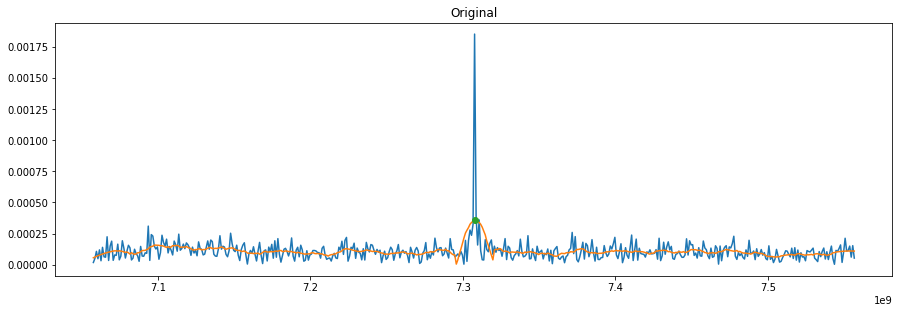

In [5]:
resonator_freq, _ = run_resonator_spectroscopy(mc, sequence, ro_pulse, **settings["resonator_spectroscopy"])

### 1.1 Resonator spectroscopy smart

This is how you use resonator spectroscopy smart and how you fit. <br>
In this example the parameters for a spectroscopy when the user doesn't know where the resonator is can be like this: <br>
    "resonator_spectroscopy": {
        "span": 500e6,
        "step": 1e6
    },

In [3]:
mc, pl, ins = create_measurement_control('resonator_spectroscopy_smart')

Starting iterative measurement...
100% completed | elapsed time:    202s | time left:      0s  
100% completed | elapsed time:    202s | time left:      0s  
Resonator Frequency = 7327720000.0

Resonator LO Frequency  = 7307720000.0
Starting iterative measurement...
100% completed | elapsed time:     17s | time left:      0s  
100% completed | elapsed time:     17s | time left:      0s  
Resonator Frequency = 7327720000.0

Resonator LO Frequency  = 7307720000.0


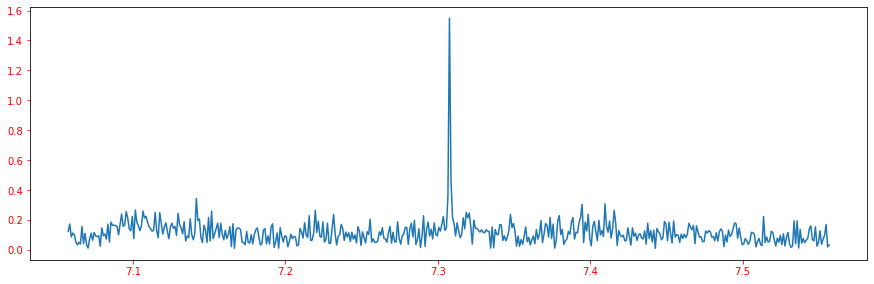

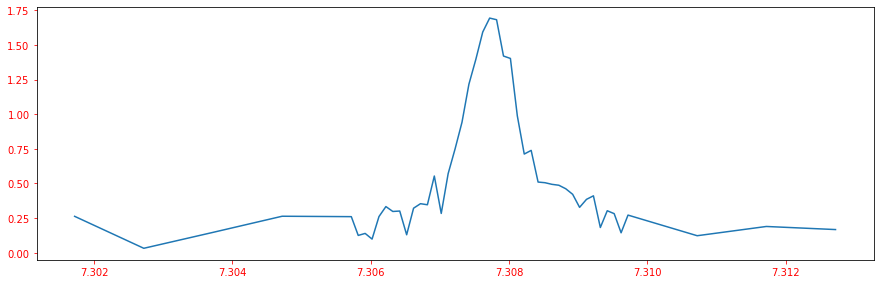

In [4]:
resonator_freq, _ = run_resonator_spectroscopy_smart(mc, **settings["resonator_spectroscopy"])

(7.307748480172877, 0.0008228644579781526, 8880.865383502687)

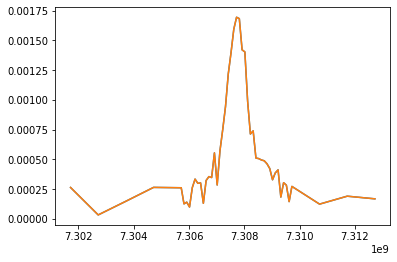

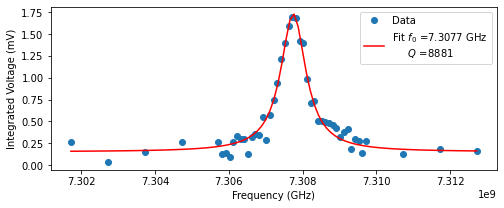

In [3]:
lorentzian_fit("last", max)

### 1.2. Punchout 

In [5]:
mc, pl, ins = create_measurement_control('punchout')

Starting iterative measurement...
100% completed | elapsed time:    162s | time left:      0s  
100% completed | elapsed time:    162s | time left:      0s  
Resonator Frequency = 7327720000.0

Resonator LO Frequency  = 7307720000.0


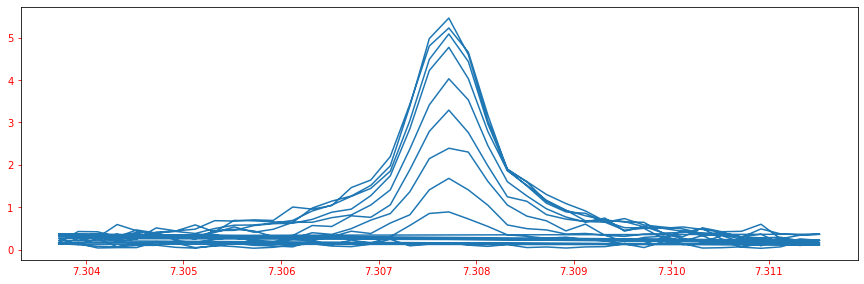

In [6]:
resonator_freq, _ = run_punchout(mc, resonator_freq, **settings["punchout"])

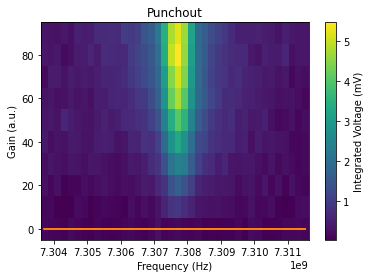

In [7]:
plot_punchout()

<div class="alert-warning">
WARNING: this measurement shows no splitting because the attenuation needs to be changed manually to a lower one. <br>
    In order to automate this a step attenuator controlled by ethernet is going to be installed (pending)
</div>

## 2. Qubit spec

In [4]:
mc, pl, ins = create_measurement_control('qubit_spectroscopy')

In [5]:
def get_pulse_sequence(duration=150):
    qc_pulse = pulses.Pulse(start=0,
                            frequency=100e6,
                            amplitude=0.4,
                            duration=duration,
                            phase=0,
                            shape=Gaussian(4000 / 5))
    ro_pulse = pulses.ReadoutPulse(start=duration + 4,
                                   frequency=20e6,
                                   amplitude=0.4,
                                   duration=2000,
                                   phase=0,
                                   shape=Rectangular())
    sequence = pulses.PulseSequence()
    sequence.add(qc_pulse)
    sequence.add(ro_pulse)
    return sequence, qc_pulse, ro_pulse

sequence, qc_pulse, ro_pulse = get_pulse_sequence()

Starting iterative measurement...
100% completed | elapsed time:    101s | time left:      0s  
100% completed | elapsed time:    101s | time left:      0s  3642000000.0
Qubit Frequency = 3742000000.0
50
50


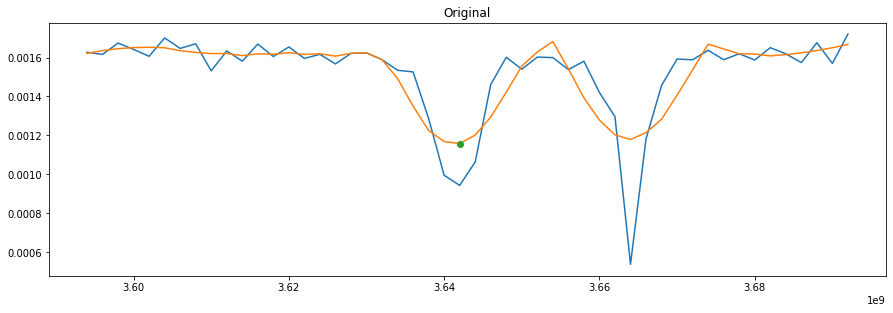

In [6]:
resonator_freq = 7.32772e9 
qubit_freq, _ = run_qubit_spectroscopy(mc, resonator_freq, sequence, qc_pulse, ro_pulse, **settings["qubit_spectroscopy"])

## 2.1. Qubit Spectroscopy smart

The only external parameter is resonator_freq which is automatically found by resonator_spectroscopy_smart

<div class="alert-warning">
WARNING: this measurement is dangerous to be automated. I was automatically getting the minimum value as the qubit frequency and
turned out to be the leakage. <br>
It's pending how to solve this in an automated way. <br>
If it's always going to be the second minimum we can look for the second but it will depend on the span also. <br>
The run_qubit_spectroscopy method seems to do that.
</div>

You can use lorentzian_fit(-,min) to fit a lorentzian like the one for the qubit.

### 2.2. Qubit spectroscopy with variation in gain 

This is useful to validate that you are looking into the correct qubit frequency and not the leakage since you see variation in the BW. <br>
Also is useful because at high enough power there is a two photon effect where you can infer f12 from that.

In [3]:
mc, pl, ins = create_measurement_control('qubit_spectroscopy')

Starting iterative measurement...
100% completed | elapsed time:    442s | time left:      0s  
100% completed | elapsed time:    442s | time left:      0s  
Qubit Frequency = 3539000000.0

Qubit LO Frequency  = 3639000000.0


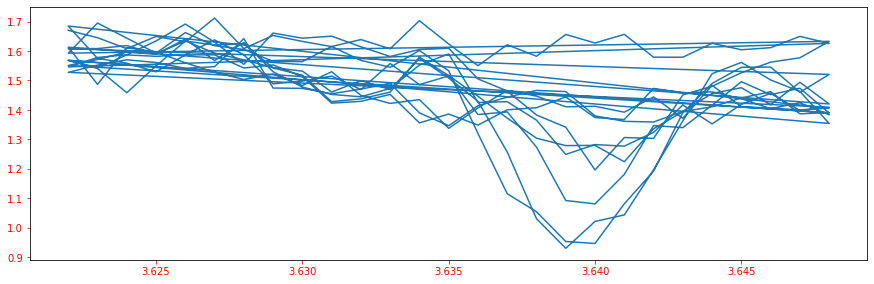

In [4]:
resonator_freq = 7.32772e9 
qubit_freq = 3.7420e9
qubit_freq, _ = run_qubit_spectroscopy_gain(mc, resonator_freq, qubit_freq)

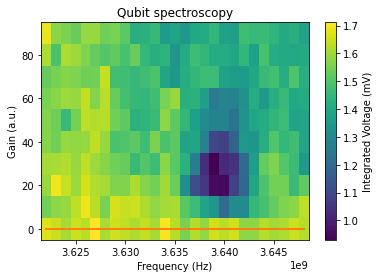

In [3]:
plot_2D("20220105-112343-591-e7c33d-Qubit Spectroscopy Gain", "qubit")

<div class="alert-danger">
DANGER: To see the splitting we need to do the spectroscopy at 20dBm. However it seems that the mixer has a P1dB=4dBm which is roughly the 1V so gain 1. <br>
    We can check what happens if we try to measure at high power (qcm max output is 5V). Otherwise we cannot measure this without changing the setup.
</div>

## 3. Rabi

### Rabi_pulse length

In [3]:
mc, pl, ins = create_measurement_control('Rabi_pulse_length')

In [4]:
def get_pulse_sequence(duration=150):
    qc_pulse = pulses.Pulse(start=0,
                            frequency=100e6,
                            amplitude=0.5,
                            duration=duration,
                            phase=0,
                            shape=Gaussian(4000 / 5))
    ro_pulse = pulses.ReadoutPulse(start=duration + 4,
                                   frequency=20e6,
                                   amplitude=0.4,
                                   duration=2000,
                                   phase=0,
                                   shape=Rectangular())
    sequence = pulses.PulseSequence()
    sequence.add(qc_pulse)
    sequence.add(ro_pulse)
    return sequence, qc_pulse, ro_pulse

sequence, qc_pulse, ro_pulse = get_pulse_sequence()

In [9]:
import diagnostics_Yifei
from imp import reload
reload(diagnostics_Yifei)
from diagnostics_Yifei import run_rabi_pulse_length

resonator_freq = 7.32772e9
qubit_freq = 3.742e9

run_rabi_pulse_length(mc, resonator_freq, qubit_freq, sequence, qc_pulse, ro_pulse)

Starting iterative measurement...
100% completed | elapsed time:    490s | time left:      0s  
100% completed | elapsed time:    490s | time left:      0s  

### Rabi_pulse gain

In [ ]:
mc, pl, ins = create_measurement_control('Rabi_pulse_gain')

In [ ]:
def get_pulse_sequence(duration=150):
    qc_pulse = pulses.Pulse(start=0,
                            frequency=100e6,
                            amplitude=0.4,
                            duration=duration,
                            phase=0,
                            shape=Gaussian(4000 / 5))
    ro_pulse = pulses.ReadoutPulse(start=duration + 4,
                                   frequency=20e6,
                                   amplitude=0.4,
                                   duration=2000,
                                   phase=0,
                                   shape=Rectangular())
    sequence = pulses.PulseSequence()
    sequence.add(qc_pulse)
    sequence.add(ro_pulse)
    return sequence, qc_pulse, ro_pulse

sequence, qc_pulse, ro_pulse = get_pulse_sequence()

In [ ]:
resonator_freq = 7.32772e9
qubit_freq = 3.742e9
run_rabi_pulse_gain(mc, resonator_freq, qubit_freq, sequence, qc_pulse, ro_pulse)

### Rabi_2D

In [3]:
mc, pl, ins = create_measurement_control('Rabi_pulse_length_and_gain')

In [4]:
def get_pulse_sequence(duration=150):
    qc_pulse = pulses.Pulse(start=0,
                            frequency=100e6,
                            amplitude=0.4,
                            duration=duration,
                            phase=0,
                            shape=Gaussian(4000 / 5))
    ro_pulse = pulses.ReadoutPulse(start=duration + 4,
                                   frequency=20e6,
                                   amplitude=0.4,
                                   duration=2000,
                                   phase=0,
                                   shape=Rectangular())
    sequence = pulses.PulseSequence()
    sequence.add(qc_pulse)
    sequence.add(ro_pulse)
    return sequence, qc_pulse, ro_pulse

sequence, qc_pulse, ro_pulse = get_pulse_sequence()

In [5]:
resonator_freq = 7.32772e9
qubit_freq = 3.742e9
run_rabi_pulse_length_and_gain(mc, resonator_freq, qubit_freq, sequence, qc_pulse, ro_pulse)

Starting iterative measurement...
100% completed | elapsed time:  31562s | time left:      0s  
100% completed | elapsed time:  31562s | time left:      0s  

## 4. T1 measurement

In [3]:
mc, pl, ins = create_measurement_control('t1')

In [ ]:
import diagnostics_Yifei_merged
from imp import reload
reload(diagnostics_Yifei_merged)
from diagnostics_Yifei_merged import run_t1
import time

resonator_freq = 7.32772e9
qubit_freq = 3.742e9 
pi_pulse_gain = 0.5
pi_pulse_length = 117

def get_pulse_sequence(duration=pi_pulse_length):
    qc_pulse = pulses.Pulse(start=0,
                            frequency=100e6,
                            amplitude=0.5,
                            duration=duration,
                            phase=0,
                            shape=Gaussian(4000 / 5))
    ro_pulse = pulses.ReadoutPulse(start=duration + 4,
                                   frequency=20e6,
                                   amplitude=0.4,
                                   duration=2000,
                                   phase=0,
                                   shape=Rectangular())
    sequence = pulses.PulseSequence()
    sequence.add(qc_pulse)
    sequence.add(ro_pulse)
    return sequence, qc_pulse, ro_pulse

sequence, qc_pulse, ro_pulse = get_pulse_sequence()

for i in range (100):
    run_t1(mc, resonator_freq, qubit_freq, pi_pulse_gain, pi_pulse_length, sequence, qc_pulse, ro_pulse, **settings["t1"])
    time.sleep(600)

Starting iterative measurement...
100% completed | elapsed time:     74s | time left:      0s  
100% completed | elapsed time:     74s | time left:      0s  Starting iterative measurement...
100% completed | elapsed time:     72s | time left:      0s  
100% completed | elapsed time:     72s | time left:      0s  Starting iterative measurement...
100% completed | elapsed time:     75s | time left:      0s  
100% completed | elapsed time:     75s | time left:      0s  Starting iterative measurement...
100% completed | elapsed time:     68s | time left:      0s  
100% completed | elapsed time:     68s | time left:      0s  Starting iterative measurement...
100% completed | elapsed time:     75s | time left:      0s  
100% completed | elapsed time:     75s | time left:      0s  Starting iterative measurement...
100% completed | elapsed time:     69s | time left:      0s  
100% completed | elapsed time:     69s | time left:      0s  Starting iterative measurement...
100% completed | elapsed

C:\Users\qilim\anaconda3\envs\quantify-env-1\lib\site-packages\pyqtgraph\graphicsItems\ScatterPlotItem.py:974: RuntimeWarning: All-NaN slice encountered
  self.bounds[ax] = (np.nanmin(d) - self._maxSpotWidth*0.7072, np.nanmax(d) + self._maxSpotWidth*0.7072)
C:\Users\qilim\anaconda3\envs\quantify-env-1\lib\site-packages\pyqtgraph\graphicsItems\ScatterPlotItem.py:974: RuntimeWarning: All-NaN slice encountered
  self.bounds[ax] = (np.nanmin(d) - self._maxSpotWidth*0.7072, np.nanmax(d) + self._maxSpotWidth*0.7072)
C:\Users\qilim\anaconda3\envs\quantify-env-1\lib\site-packages\pyqtgraph\graphicsItems\ScatterPlotItem.py:974: RuntimeWarning: All-NaN slice encountered
  self.bounds[ax] = (np.nanmin(d) - self._maxSpotWidth*0.7072, np.nanmax(d) + self._maxSpotWidth*0.7072)
C:\Users\qilim\anaconda3\envs\quantify-env-1\lib\site-packages\pyqtgraph\graphicsItems\ScatterPlotItem.py:974: RuntimeWarning: All-NaN slice encountered
  self.bounds[ax] = (np.nanmin(d) - self._maxSpotWidth*0.7072, np.nanmax(

100% completed | elapsed time:     72s | time left:      0s  
100% completed | elapsed time:     72s | time left:      0s  Starting iterative measurement...
100% completed | elapsed time:     73s | time left:      0s  
100% completed | elapsed time:     73s | time left:      0s  Starting iterative measurement...
100% completed | elapsed time:     71s | time left:      0s  
100% completed | elapsed time:     71s | time left:      0s  Starting iterative measurement...
100% completed | elapsed time:     70s | time left:      0s  
100% completed | elapsed time:     70s | time left:      0s  Starting iterative measurement...
100% completed | elapsed time:     71s | time left:      0s  
100% completed | elapsed time:     71s | time left:      0s  Starting iterative measurement...
100% completed | elapsed time:     73s | time left:      0s  
100% completed | elapsed time:     73s | time left:      0s  Starting iterative measurement...
100% completed | elapsed time:     78s | time left:      0

C:\Users\qilim\anaconda3\envs\quantify-env-1\lib\site-packages\pyqtgraph\graphicsItems\ScatterPlotItem.py:974: RuntimeWarning: All-NaN slice encountered
  self.bounds[ax] = (np.nanmin(d) - self._maxSpotWidth*0.7072, np.nanmax(d) + self._maxSpotWidth*0.7072)
C:\Users\qilim\anaconda3\envs\quantify-env-1\lib\site-packages\pyqtgraph\graphicsItems\ScatterPlotItem.py:974: RuntimeWarning: All-NaN slice encountered
  self.bounds[ax] = (np.nanmin(d) - self._maxSpotWidth*0.7072, np.nanmax(d) + self._maxSpotWidth*0.7072)
C:\Users\qilim\anaconda3\envs\quantify-env-1\lib\site-packages\pyqtgraph\graphicsItems\ScatterPlotItem.py:974: RuntimeWarning: All-NaN slice encountered
  self.bounds[ax] = (np.nanmin(d) - self._maxSpotWidth*0.7072, np.nanmax(d) + self._maxSpotWidth*0.7072)
C:\Users\qilim\anaconda3\envs\quantify-env-1\lib\site-packages\pyqtgraph\graphicsItems\ScatterPlotItem.py:974: RuntimeWarning: All-NaN slice encountered
  self.bounds[ax] = (np.nanmin(d) - self._maxSpotWidth*0.7072, np.nanmax(

100% completed | elapsed time:     72s | time left:      0s  
100% completed | elapsed time:     72s | time left:      0s  Starting iterative measurement...
100% completed | elapsed time:     73s | time left:      0s  
100% completed | elapsed time:     73s | time left:      0s  Starting iterative measurement...
100% completed | elapsed time:     74s | time left:      0s  
100% completed | elapsed time:     74s | time left:      0s  Starting iterative measurement...
100% completed | elapsed time:     71s | time left:      0s  
100% completed | elapsed time:     71s | time left:      0s  Starting iterative measurement...
100% completed | elapsed time:     71s | time left:      0s  
100% completed | elapsed time:     71s | time left:      0s  

### 4.1 Analyzing T1 historic data

This is how you fit a T1 on a specific file:

18256.940944957463

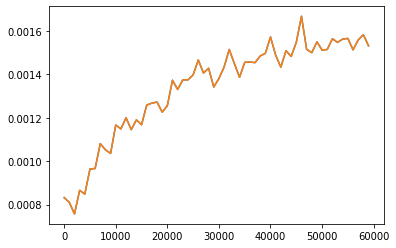

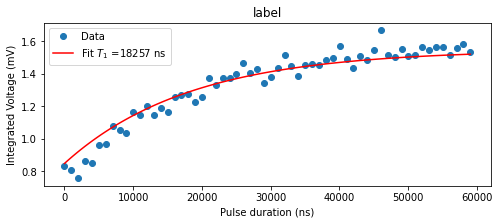

In [3]:
t1_fit("20220105-052007-125-3f41b6-T1",True)

This is how you fit a T1 on the last measured file:

14339.768953844456

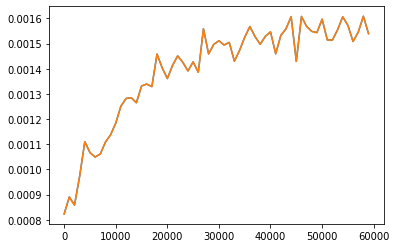

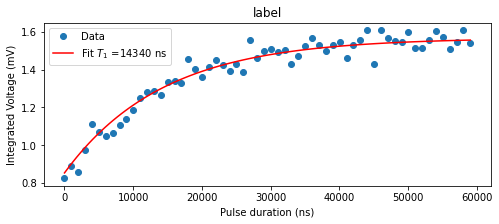

In [4]:
t1_fit("last",True)

To avoid the plotting just set the second parameter to False

This is how you plot the histogram for a batch of T1 measurements stored in T1_batch folder inside data folder

The model function generated NaN values and the fit aborted! Please check your model function and/or set boundaries on parameters where applicable. In cases like this, using "nan_policy='omit'" will probably not work.
Problem with file - 20220104-172132-163-7063ea-T1


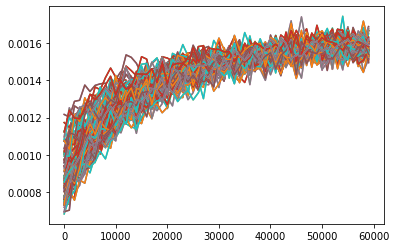

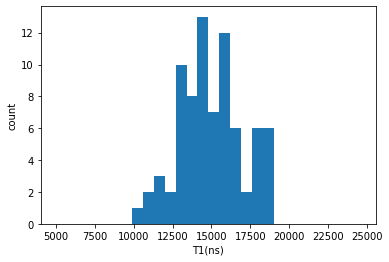

In [5]:
t1_histogram()

## 5. Ramsey

In [ ]:
mc, pl, ins = create_measurement_control('ramsey')

In [ ]:
resonator_freq = 7.32772e9
qubit_freq = 3.742e9 
pi_pulse_gain = 0.5
pi_pulse_length = 117
pi_pulse_amplitude = 0.5

run_ramsey(mc, resonator_freq, qubit_freq, pi_pulse_gain, pi_pulse_length, pi_pulse_amplitude, **settings["ramsey"])

## 6. Echo

In [ ]:
mc, pl, ins = create_measurement_control('spin_echo')

In [1]:
run_spin_echo(mc, resonator_freq, qubit_freq, pi_pulse_gain, pi_pulse_length, pi_pulse_amplitude, **settings["spin_echo"])